In [1]:
import os
from os.path import isdir, isfile, join
import pandas as pd 
import numpy as np
import tifffile as tiff 
import cv2
import random 

import torch
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
import os
import cv2
import gc
import random
from albumentations import *
import matplotlib.pyplot as plt
from torchvision import transforms as torch_transform
import rasterio

import pytorch_lightning as pl
import segmentation_models_pytorch as smp
from segmentation_models_pytorch import utils as smp_utils

import ssl

ssl._create_default_https_context = ssl._create_unverified_context
import warnings
warnings.filterwarnings("ignore")


In [2]:
DATA_PATH = "../../hubmap-organ-segmentation"
image_folder = join(DATA_PATH, "train_images")
label_file = join(DATA_PATH, "train.csv")

mean = np.array([0.7720342, 0.74582646, 0.76392896])
std = np.array([0.24745085, 0.26182273, 0.25782376])


INPUT_SIZE = 512
NUM_WORKERS = 0
BATCH_SIZE = 1


In [3]:
def mask2rle(img):
    '''
    img: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    pixels= img.T.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)
 
def rle2mask(mask_rle, shape=(1600,256)):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (width,height) of array to return 
    Returns numpy array, 1 - mask, 0 - background

    '''
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape).T


In [4]:
train_ids = [10044, 10274, 10666, 10912, 10971, 1184, 12233, 12244, 1229, 13483, 13942, 14396, 14407, 1500, 15706, 15732, 16149, 16609, 16659, 1690, 17143, 17187, 17455, 17828, 18422, 19084, 1955, 19569, 20247, 20428, 20955, 21086, 21155, 2174, 22016, 22059, 22995, 23009, 23640, 23828, 23959, 23961, 24194, 24269, 24961, 25430, 26982, 27471, 28318, 28622, 29213, 29223, 29296, 29307, 29809, 30080, 30294, 30355, 30414, 30424, 30765, 31898, 31958, 32009, 32126, 32412, 32741, 3409, 435, 4639, 4658, 4802, 4944, 5287, 5317, 5785, 5932, 5995, 6120, 10392, 10610, 10703, 10992, 1123, 11448, 11645, 12026, 12466, 12483, 144, 15551, 18792, 19179, 19360, 19377, 19507, 19997, 2079, 20831, 21358, 22236, 2279, 22953, 24833, 25472, 26664, 27781, 27803, 28126, 28657, 28748, 28963, 29143, 29690, 30201, 3054, 3057, 30581, 31290, 31675, 31733, 32231, 3959, 4404, 10488, 11064, 11629, 1220, 12452, 12476, 127, 12827, 13189, 14388, 15067, 15124, 15329, 16564, 1731, 1878, 20563, 23252, 24782, 25516, 25945, 26480, 27232, 2793, 28052, 28189, 28429, 29610, 30084, 30394, 30500, 31139, 31571, 31800, 32151, 4301, 4412, 4776, 5086, 5552, 10611, 11497, 1157, 12784, 13034, 13260, 14756, 15005, 15192, 15787, 15860, 16163, 16214, 16216, 16362, 164, 16711, 17422, 18121, 18401, 18426, 18449, 18777, 19048, 19533, 20302, 20440, 20478, 20520, 20794, 21021, 21112, 21129, 21195, 21321, 22035, 22133, 22544, 22718, 22741, 23051, 23243, 2344, 23665, 23760, 23880, 24097, 24100, 24222, 2424, 24241, 2447, 24522, 2500, 25620, 26101, 26174, 2668, 27298, 27350, 27468, 27616, 27879, 28262, 28436, 2874, 28823, 28940, 29238, 2943, 30194, 30224, 30250, 30474, 3083, 30876, 31698, 31709, 32325, 32527, 4066, 4265, 4777, 5099, 10651, 10892, 11662, 1168, 11890, 12174, 12471, 13396, 13507, 14183, 14674, 15499, 15842, 16728, 16890, 17126, 18445, 1850, 18900, 203, 21039, 21501, 21812, 22310, 23094, 25298, 25641, 25689, 26319, 26780, 26886, 2696, 27128, 27340, 27587, 27861, 28045, 28791, 29180, 29424, 29820, 31406, 31727, 31799, 3303, 351, 4062, 4561, 5832]
val_ids = [6390, 6730, 6794, 737, 7397, 7706, 7902, 8227, 8388, 8638, 8842, 9231, 928, 9358, 5583, 6722, 7169, 8116, 8876, 8894, 9407, 9453, 5777, 686, 7359, 8151, 8231, 8343, 9387, 9450, 5102, 6021, 62, 6318, 660, 6807, 7569, 7970, 8502, 9437, 9445, 9470, 9517, 9769, 9791, 6121, 6611, 676, 8222, 8402, 8450, 8752, 9777, 9904]

In [23]:
print("number of train ", len(train_ids))
print("number of val ", len(val_ids))

number of train  297
number of val  54


In [5]:
def img2tensor(img,dtype:np.dtype=np.float32):
    if img.ndim==2 : img = np.expand_dims(img,2)
    img = np.transpose(img,(2,0,1))
    return torch.from_numpy(img.astype(dtype, copy=False))
     
def get_train_aug(p=1.0):
    return Compose([
        Resize(INPUT_SIZE, INPUT_SIZE), 
        HorizontalFlip(),
        VerticalFlip(),
        RandomRotate90(),
        ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.2, rotate_limit=15, p=0.9, 
                         border_mode=cv2.BORDER_REFLECT),
        OneOf([
            OpticalDistortion(p=0.3),
            GridDistortion(p=.1),
            IAAPiecewiseAffine(p=0.3),
        ], p=0.3),
        OneOf([
            HueSaturationValue(10,15,10),
            CLAHE(clip_limit=2),
            RandomBrightnessContrast(),            
        ], p=0.3),
    ], p=p)


def get_val_aug(p=1.0):
    return Compose([
        Resize(INPUT_SIZE, INPUT_SIZE), 
    ])

In [6]:
class HuBMAPDataset(Dataset):
    def __init__(self, image_folder, train=True, tfms=None):
        if train:
            self.ids = train_ids
        else:
            self.ids = val_ids
        
        self.image_folder = image_folder
        self.data = pd.read_csv(label_file)
        print(self.image_folder)
        self.fnames = [fname for fname in os.listdir(self.image_folder)]
        self.train = train
        self.tfms = tfms
        
    def __len__(self):
        return len(self.ids)
    
    def __getitem__(self, idx):
        data = self.data[self.data.id == self.ids[idx]]
        img_id = data['id'].values[0]
        rle = data['rle'].tolist()
        img_path = join(self.image_folder, str(img_id) + ".tiff")
        img = tiff.imread(img_path)
        img_shape = (img.shape[1], img.shape[0])    
        mask = rle2mask(rle[0], img_shape)

        if self.tfms is not None:
            augmented = self.tfms(image=img,mask=mask)
            img,mask = augmented['image'],augmented['mask']
        return img2tensor((img/255.0 - mean)/std),img2tensor(mask)


In [7]:
train_dataset = HuBMAPDataset(image_folder, True, get_train_aug(1.0))
val_dataset = HuBMAPDataset(image_folder, False, get_val_aug(1.0))


../../hubmap-organ-segmentation\train_images
../../hubmap-organ-segmentation\train_images


In [8]:
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE,
            num_workers=NUM_WORKERS, drop_last=True, pin_memory=True, shuffle=True)

val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE,
            num_workers=NUM_WORKERS, drop_last=True, pin_memory=True, shuffle=True)

In [9]:
url_pretrained_model = "https://vcl.ucsd.edu/coat/pretrained/tasks/Deformable-DETR/coat_small_deformable_detr_8a86ba55.pth"

In [10]:
!git clone git@github.com:NguyenVanThanhHust/CoaT.git

fatal: destination path 'CoaT' already exists and is not an empty directory.


In [11]:
ENCODER = 'se_resnext50_32x4d'
ENCODER_WEIGHTS = 'imagenet'
CLASSES = ['tissue']
ACTIVATION = 'sigmoid'
DEVICE = 'cuda'

In [28]:
# create segmentation model with pretrained encoder
model = smp.Unet(
    encoder_name=ENCODER, 
    encoder_weights=ENCODER_WEIGHTS, 
    classes=len(CLASSES), 
    activation=ACTIVATION,
)

In [14]:
# Dice/F1 score - https://en.wikipedia.org/wiki/S%C3%B8rensen%E2%80%93Dice_coefficient
# IoU/Jaccard score - https://en.wikipedia.org/wiki/Jaccard_index

loss = smp.utils.losses.DiceLoss()
metrics = [
    smp.utils.metrics.IoU(threshold=0.5),
]

optimizer = torch.optim.SGD([ 
    dict(params=model.parameters(), lr=0.00001),
])

In [15]:
# create epoch runners 
# it is a simple loop of iterating over dataloader`s samples
train_epoch = smp.utils.train.TrainEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    optimizer=optimizer,
    device=DEVICE,
    verbose=True,
)

valid_epoch = smp.utils.train.ValidEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    device=DEVICE,
    verbose=True,
)

In [ ]:
# train model for 40 epochs

max_score = 0

for i in range(0, 400):
    
    print('\nEpoch: {}'.format(i))
    train_logs = train_epoch.run(train_dataloader)
    valid_logs = valid_epoch.run(val_dataloader)
    
    # do something (save model, change lr, etc.)
    if max_score < valid_logs['iou_score']:
        max_score = valid_logs['iou_score']
        torch.save(model, os.path.join("models", 'model_{}.pth'.format(i)))
        print('Model saved!')
        
    if i == 25:
        optimizer.param_groups[0]['lr'] = 1e-5
        print('Decrease decoder learning rate to 1e-5!')


Epoch: 0
valid: 100%|██████████████████████████████████████| 54/54 [00:06<00:00,  8.74it/s, dice_loss - 0.848, iou_score - 0.11]
Model saved!

Epoch: 1
valid: 100%|███████████████████████████████████| 54/54 [00:06<00:00,  8.93it/s, dice_loss - 0.8469, iou_score - 0.1088]

Epoch: 2
valid: 100%|██████████████████████████████████| 54/54 [00:06<00:00,  8.23it/s, dice_loss - 0.8476, iou_score - 0.09837]

Epoch: 3
valid:  26%|█████████                          | 14/54 [00:02<00:06,  6.27it/s, dice_loss - 0.8509, iou_score - 0.1074]

In [27]:
pretrained_model = torch.load("best_model.pth")

In [25]:
type(best_model)

segmentation_models_pytorch.decoders.unet.model.Unet

In [17]:
# https://smp.readthedocs.io/en/latest/insights.html?highlight=custom%20encoder#creating-your-own-encoder

In [18]:
# load best saved checkpoint
best_model = torch.load('./best_model.pth')

In [19]:
val_dataset = HuBMAPDataset(image_folder, False, get_val_aug(1.0))
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE,
            num_workers=NUM_WORKERS, drop_last=True, pin_memory=True, shuffle=True)

../../hubmap-organ-segmentation\train_images


In [20]:
# evaluate model on test set
test_epoch = smp.utils.train.ValidEpoch(
    model=best_model,
    loss=loss,
    metrics=metrics,
    device=DEVICE,
)

logs = test_epoch.run(val_dataloader)



valid: 100%|███████████████████████████████████| 54/54 [00:05<00:00,  9.38it/s, dice_loss - 0.8457, iou_score - 0.1096]


In [21]:
# helper function for data visualization
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    plt.show()


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


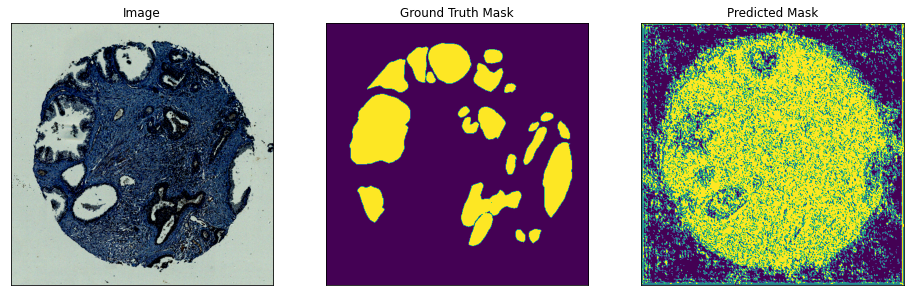

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


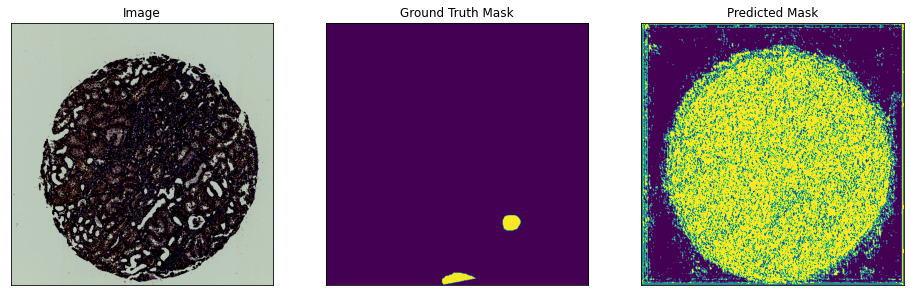

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


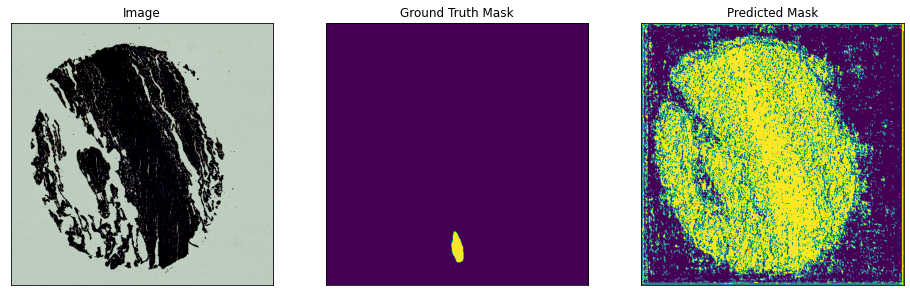

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


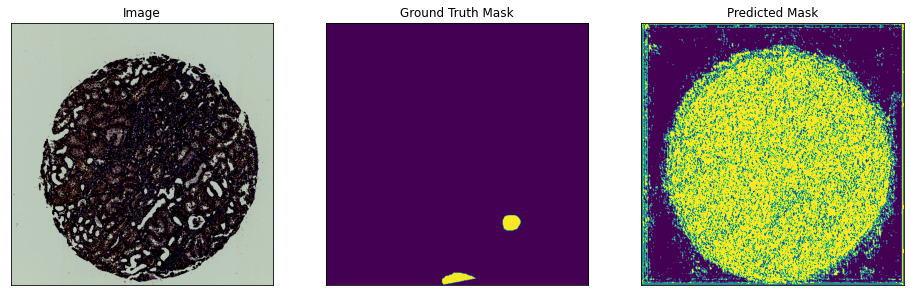

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


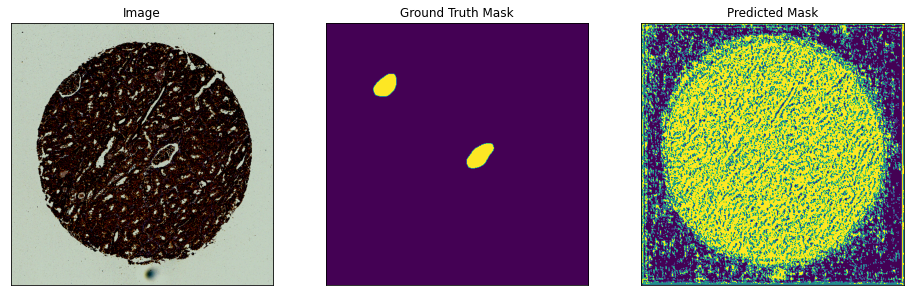

In [22]:


for i in range(5):
    n = np.random.choice(len(val_dataset))
    
    image, gt_mask = val_dataset[n]
    
    gt_mask = gt_mask.squeeze()
    
    x_tensor = image.to(DEVICE).unsqueeze(0)
    pr_mask = best_model.predict(x_tensor)
    pr_mask = (pr_mask.squeeze().cpu().numpy().round())
    
    image_vis = image.detach().cpu().numpy()
    image_vis = np.transpose(image_vis, (1, 2, 0))
    visualize(
        image=image_vis, 
        ground_truth_mask=gt_mask, 
        predicted_mask=pr_mask
    )

